In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from toolbox.utils.plotting import draw_ellipse
import lsst.afw.geom
from matplotlib.patches import Ellipse
from hscana import MyCat
from candy.params import params
shape_model = 'shape.hsm.moments'

Here's how the semi-major/minor axes relate to the moments:

```python 
Mxx = moments[0].getIxx()
Myy = moments[0].getIyy()
Mxy = moments[0].getIxy()

Muu_p_Mvv = Mxx + Myy
Muu_m_Mvv = np.sqrt((Mxx - Myy)**2 + 4*Mxy**2)
Muu = 0.5*(Muu_p_Mvv + Muu_m_Mvv)
Mvv = 0.5*(Muu_p_Mvv - Muu_m_Mvv)
theta = 0.5*np.arctan2(2*Mxy, Mxx - Myy)
a = np.sqrt(Muu)
b = np.sqrt(Mvv)

print a, b, theta

print axes[0].getA(), axes[0].getB(), axes[0].getTheta()
```

In [2]:
def draw(candy_num):
    tract, patch, parent = params[candy_num]
    mycat = MyCat(tract=tract, patch=patch, usewcs=True)
    mycat.apply_cuts(mycat.cat.get('parent')==parent)
    children = mycat.cat

    moments = []
    separable = []
    axes = []

    for i, child in enumerate(children):
        affine = mycat.wcs.linearizePixelToSky(child.get('coord'), lsst.afw.geom.degrees)
        shape = child.get(shape_model)
        moments.append(shape.transform(affine.getLinear()))
        separable.append(lsst.afw.geom.ellipses.SeparableDistortionDeterminantRadius(moments[i]))
        axes.append(lsst.afw.geom.ellipses.Axes(moments[i]))

    f1, a1 = plt.subplots()
    center = np.array([0.0, 0.0])
    aa = 0.0
    bb = 0.0
    theta = []
    scale = 1.0
    for child, mom, axis in zip(children, moments, axes):
        ra, dec = child.get('coord.ra').asDegrees(), child.get('coord.dec').asDegrees()
        mu = np.array([ra, dec])
        center += mu
        a1.plot(ra, dec, 'bo')
        if not np.isnan(axis.getA()):
            aa += axis.getA()**2
            bb += axis.getB()**2
            theta.append(axis.getTheta())
        ixx, iyy, ixy = mom.getIxx(), mom.getIyy(), mom.getIxy()
        C = np.array([[ixx, ixy], [ixy, iyy]])
        draw_ellipse(mu, C, scales=[scale], ax=a1, ec='k', fc='none')
    center /= len(children)
    theta = np.median(theta)
    a1.plot(center[0], center[1], 'm*', ms=15)
    a1.add_patch(Ellipse(center, 2*scale*np.sqrt(aa), 2*scale*np.sqrt(bb), theta*180.0/np.pi, ec='r', fc='none'))
    side = 6.0/3600.0
    a1.set_xlim(center[0]-side, center[0]+side)
    a1.set_ylim(center[1]-0.8*side, center[1]+0.8*side)
    a1.invert_xaxis()

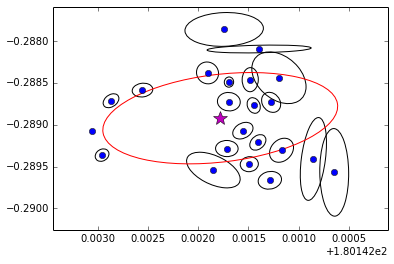

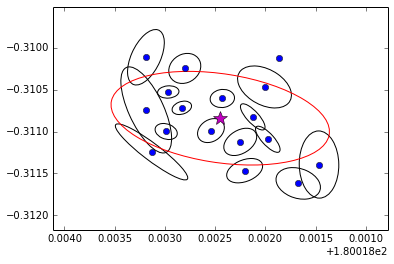

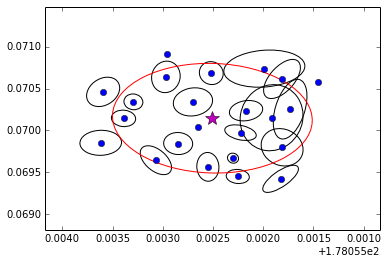

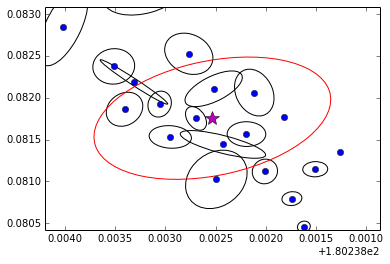

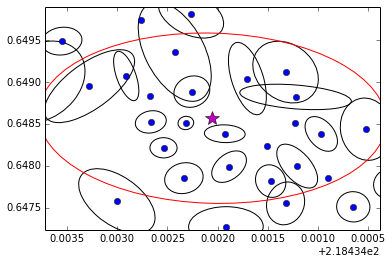

In [3]:
for i in range(5):
    draw(i+1)